In [1]:
import os
from pathlib import Path
import zipfile
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import kaggle
import scraper
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

# __What makes a good midfielder?__

#### Goalkeepers prevent opposition goals. Defenders prevent the goalkeeper from needing to prevent opposition goals. Forwards put the ball in the net, which is the point of the game, of course. However, it can be argued that midfielders are the most integral part of a football team. They will have to stop an opponent counter attack one second, and then create one for their team the next. But what makes a good midfielder? And how can you quantify a midfielder's quality?

#### As people who watch the game, we can usually judge how good a player is by watching them play. However, this judgement will always be subjective. How can we define an objective metric for how good a player is? We can come close, with player ratings and market values. However, since I have found no easy way to acquire any data for whole season player ratings, we will only work with market values. There is still a subjective element in these, and they depend on more than just the quality of the player, however they are quite close to an objective metric and we will try to exploit them to create a hopefully even more accurate metric, as shown later on.

First, let's start by getting player market values from [Transfermarkt](https://www.transfermarkt.com/), using an [auto-updated dataset from Kaggle](https://www.kaggle.com/davidcariboo/player-scores). We will filter it to only include players from the top 5 leagues.

In [2]:
players = 'players.csv'

if not os.path.isfile('data/' + players):
    # kaggle.api.authenticate()
    kaggle.api.dataset_download_cli('davidcariboo/player-scores', path='data/')

    with zipfile.ZipFile('data/player-scores.zip', 'r') as f:
        f.extract(players, 'data/')

In [3]:
players = pd.read_csv('data/' + players)
players

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name
0,597,Aleksandr,Hleb,Aleksandr Hleb,2016,2696,aleksandr-hleb,UdSSR,Minsk,Belarus,...,NaN,NaN,NaN,19000000.0,NaN,fair-sport GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/aleksandr-hleb...,RU1,Krylya Sovetov Samara
1,1428,Mike,Hanke,Mike Hanke,2013,60,mike-hanke,Germany,Hamm,Germany,...,right,185.0,NaN,5000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/mike-hanke/pro...,L1,SC Freiburg
2,1560,Youssef,El Akchaoui,Youssef El Akchaoui,2012,306,youssef-el-akchaoui,Netherlands,Dordrecht,Morocco,...,NaN,NaN,NaN,1750000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/youssef-el-akc...,NL1,SC Heerenveen
3,1587,Mario,Eggimann,Mario Eggimann,2012,42,mario-eggimann,Switzerland,Brugg,Switzerland,...,right,190.0,NaN,3000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/mario-eggimann...,L1,Hannover 96
4,1726,Heiko,Westermann,Heiko Westermann,2016,610,heiko-westermann,Germany,Alzenau,Germany,...,right,190.0,NaN,9000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/heiko-westerma...,NL1,Ajax Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28471,199337,Rifat,Erdem,Rifat Erdem,2013,2293,rifat-erdem,Turkey,Konya,Turkey,...,right,NaN,NaN,100000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/rifat-erdem/pr...,TR1,Konyaspor
28472,209569,Mücahit,Atalay,Mücahit Atalay,2020,2293,mucahit-atalay,Turkey,Trabzon,Turkey,...,right,186.0,NaN,250000.0,2023-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/mucahit-atalay...,TR1,Konyaspor
28473,221118,Patrick Friday,Eze,Patrick Friday Eze,2017,2293,patrick-friday-eze,Nigeria,Kaduna,Nigeria,...,right,187.0,200000.0,775000.0,2023-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/patrick-friday...,TR1,Konyaspor
28474,273053,Burak,Saban,Burak Saban,2018,2293,burak-saban,Netherlands,Hoorn,Netherlands,...,both,177.0,NaN,200000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/burak-saban/pr...,TR1,Konyaspor


Discarding of data that are not relevant to our analysis:

In [4]:
# only keep active players
players = players[players.last_season == 2022]

# only keep players from the top 5 leagues
top5 = ['GB1', 'L1', 'ES1', 'IT1', 'FR1']
players = players[players.current_club_domestic_competition_id.isin(top5)]
players.dropna(subset=['market_value_in_eur'], inplace=True)

players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
today = pd.to_datetime('today')
players['age'] = (today - players['date_of_birth']).dt.days / 365
players['age'] = players['age'].round()

players = players[['name', 'market_value_in_eur', 'age']]
players.columns = ['Name', 'Value', 'Age']
players = players.astype({'Value': int, 'Age': int})

players.sort_values('Value', ascending=False, inplace=True)
players.reset_index(inplace=True, drop=True)

players

,Name,Value,Age
0,Kylian Mbappé,180000000,25
1,Erling Haaland,170000000,23
2,Vinicius Junior,120000000,23
3,Jude Bellingham,120000000,20
4,Jamal Musiala,110000000,21
...,...,...,...
2635,Davide Marfella,50000,24
2636,Simon Walde,50000,19
2637,Javi Guerra,50000,20
2638,Matteo Fiorenza,25000,20


It will be interesting to first explore how age affects market value, since it is a common perception that a player's value will increase with age, until a point when they reach their peak, and then it will start to decrease. <br>
First, let's visualize the relationship between age and market value with a scatter plot.

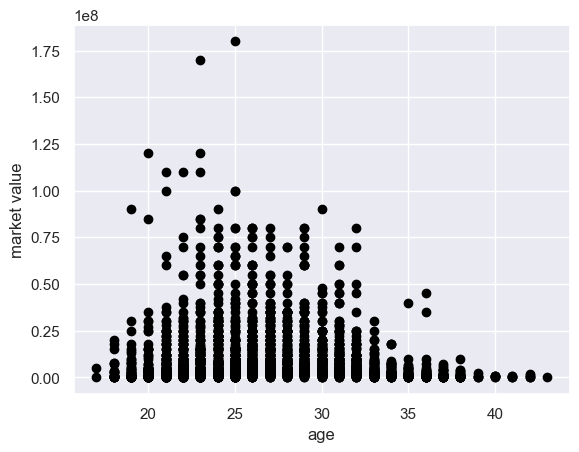

In [5]:
X = players[['Age']]
y = players['Value']

plt.scatter(X, y, color='black')
plt.xlabel('age')
plt.ylabel('market value')
plt.show()

The scatter plot somewhat confirms our intuition about the relationship between age and market value. <br>
Since we don't expect the relationship to be linear, we will fit a polynomial regression model to the data. <br>
It's worth noting that the variance is not similar throughout all ages, so the data does not meet the homoscedasticity assumption of regression, however we will ignore this for now and proceed with the regression.

In [6]:
def plot_model(model):
    x = np.arange(X.values.min(), X.values.max() + 1).reshape(-1, 1)

    plt.scatter(X, y, color='black')
    plt.plot(x, model.predict(x), color='red', linewidth=3)
    plt.xlabel('age')
    plt.ylabel('market value')
    plt.show()

R-squared: 0.05586
RMSE: 15,256,377 €


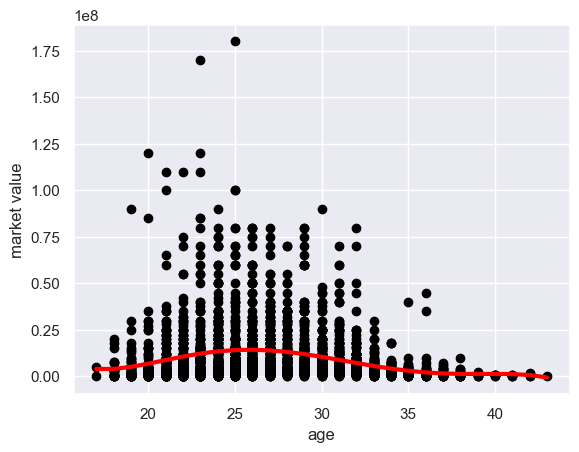

In [7]:
model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X, y)

y_pred = model.predict(X)
r2 = metrics.r2_score(y, y_pred)
rmse = metrics.mean_squared_error(y, y_pred, squared=False)

print(f'R-squared: {r2:.5f}')
print(f'RMSE: {rmse:,.0f} €')
plot_model(model)

Polynomial features of degree 2 seemed to not be good enough, and after a bit of trial and error, 5 seems to be the sweetspot, however the difference from 3 to 5 is not that big. <br>
The model seems to capture the relationship we have observed, however the R-squared is very low, and the root mean squared error is quite high. <br>
Of course, R-squared is not the perfect metric for non-linear relationships, but the lack of homoscedasticity must have also played a role in the low score of the model.

Let's now get player stats from FBRef.com using [a scraper I made](https://github.com/NikosKont/FBref-Scraper), and see if we can find a better model for predicting market value. <br>
These stats are based on performances from the 2022-23 season, for players in the top 5 leagues.

In [8]:
stats = 'stats.csv'

if os.path.isfile('data/' + stats):
    stats = pd.read_csv('data/' + stats)
else:
    stats = scraper.get_player_stats('standard', 'Big5')
    cols = stats.columns.to_numpy()
    cols[26:] += '/90'
    stats.columns = cols
    stats.drop(['Nation', 'Squad', 'Comp', 'Age', 'Born'], axis=1, inplace=True)
    stats.to_csv('data/' + stats, index=False)

stats

,Player,Pos,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,...,Gls/90,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90
0,Brenden Aaronson,"MF,FW",36,28,2372,26.4,1,3,4,1,...,0.04,0.11,0.15,0.04,0.15,0.15,0.16,0.31,0.15,0.31
1,Paxten Aaronson,"MF,DF",7,0,173,1.9,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.09,0.03,0.11,0.09,0.11
2,James Abankwah,DF,1,0,5,0.1,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,George Abbott,MF,1,0,1,0.0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Yunis Abdelhamid,DF,36,36,3240,36.0,1,2,3,1,...,0.03,0.06,0.08,0.03,0.08,0.06,0.03,0.09,0.06,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,Szymon Żurkowski,MF,2,0,32,0.4,0,1,1,0,...,0.00,2.81,2.81,0.00,2.81,0.33,0.06,0.40,0.33,0.40
2861,Szymon Żurkowski,MF,9,2,340,3.8,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.04,0.04,0.04
2862,Martin Ødegaard,MF,37,37,3127,34.7,15,7,22,15,...,0.43,0.20,0.63,0.43,0.63,0.29,0.23,0.52,0.29,0.52
2863,Milan Đurić,FW,27,13,1308,14.5,1,1,2,1,...,0.07,0.07,0.14,0.07,0.14,0.10,0.09,0.19,0.10,0.19


Because the names of the players are not exactly the same in both datasets, we will have to do some extra work to match them. <br>
We will allow a maximum of 2 characters difference between the names, and will match those that meet this criterion.

In [9]:
def match(s1, s2):
    if s1 == s2:
        return True
    if len(s1) != len(s2):
        return False
    
    diff = 0

    for c1, c2 in zip(s1, s2):
        if c1 != c2:
            diff += 1
        if diff > 2:
            return False

    return True

diff1 = np.setdiff1d(players.Name, stats.Player)
diff2 = np.setdiff1d(stats.Player, players.Name)

# find matches between the two arrays that have a maximum of one character difference
matches = []
for name1 in diff1:
    for name2 in diff2:
        if match(name1, name2):
            matches.append((name1, name2))

for name1, name2 in matches:
    stats.loc[stats.Player == name2, 'Player'] = name1

Combining the two datasets and creating a few new stats that in my opinion might be useful:

In [10]:
players = pd.merge(players, stats, left_on='Name', right_on='Player')
players.drop(['Player'], axis=1, inplace=True)
players = players[players['Pos'].str.find('MF') != -1]
players.dropna(inplace=True)

# new features
players['G-xG'] = players['Gls'] - players['xG']
players['G-xG/90'] = players['G-xG'] / players['90s']
players['G-PK-npxG'] = players['G-PK'] - players['npxG']
players['G-PK-npxG/90'] = players['G-PK-npxG'] / players['90s']
players['G-PK-npxG+xAG'] = players['G-PK-npxG'] + players['xAG']
players['G-PK-npxG+xAG/90'] = players['G-PK-npxG+xAG'] / players['90s']

players

,Name,Value,Age,Pos,MP,Starts,Min,90s,Gls,Ast,...,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90,G-xG,G-xG/90,G-PK-npxG,G-PK-npxG/90,G-PK-npxG+xAG,G-PK-npxG+xAG/90
3,Jude Bellingham,120000000,20,MF,31,30,2691,29.9,8,4,...,0.14,0.41,0.25,0.38,-0.2,-0.006689,-0.4,-0.013378,3.6,0.120401
4,Jamal Musiala,110000000,21,"MF,FW",33,26,2198,24.4,12,10,...,0.27,0.60,0.33,0.60,4.0,0.163934,4.0,0.163934,10.6,0.434426
8,Pedri,100000000,21,MF,26,22,1976,22.0,6,1,...,0.23,0.45,0.22,0.45,1.1,0.050000,1.1,0.050000,6.1,0.277273
9,Federico Valverde,100000000,25,"MF,FW",34,29,2502,27.8,7,4,...,0.23,0.38,0.15,0.38,2.7,0.097122,2.7,0.097122,9.0,0.323741
10,Aurélien Tchouaméni,90000000,24,MF,32,24,2086,23.2,0,4,...,0.10,0.17,0.08,0.17,-1.8,-0.077586,-1.8,-0.077586,0.4,0.017241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,Christian Acella,150000,21,MF,1,0,15,0.2,0,0,...,0.00,0.00,0.00,0.00,0.0,0.000000,0.0,0.000000,0.0,0.000000
2351,Jean-Mattéo Bahoya,100000,18,"FW,MF",10,2,270,3.0,0,0,...,0.12,0.29,0.17,0.29,-0.5,-0.166667,-0.5,-0.166667,-0.1,-0.033333
2352,Yanis Massolin,100000,21,MF,6,0,60,0.7,0,0,...,0.00,0.07,0.07,0.07,0.0,0.000000,0.0,0.000000,0.0,0.000000
2353,Kévin Danois,100000,19,MF,1,0,2,0.0,0,0,...,0.00,0.00,0.00,0.00,0.0,NaN,0.0,NaN,0.0,NaN


It will be interesting to see the results, by repeating the same process as before, but this time using only players with at least 5 90s played this season. This is a minimum that will ensure that the player is invovled at least to some extent, so for example academy players who are just there to fill the squad or players with long-term injuries will be excluded and not affect the results. This will also be useful later, since less involvement than that is a small sample size for a player's stats.

R-squared: 0.05979
RMSE: 16,903,872 €


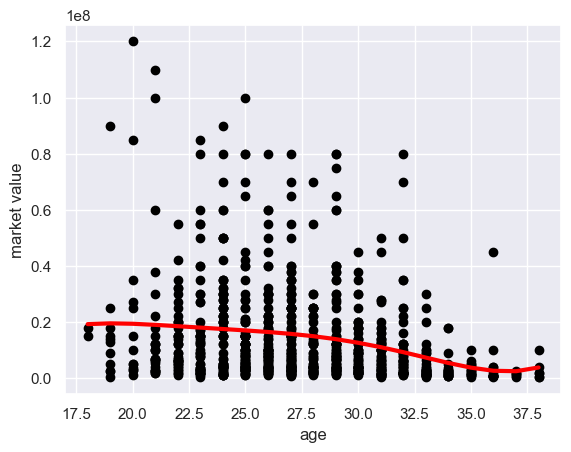

In [11]:
players = players[players['90s'] >= 5]
# players = players[players.Min >= 270]

X = players[['Age']]
y = players['Value']

model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X, y)

y_pred = model.predict(X)
r2 = metrics.r2_score(y, y_pred)
rmse = metrics.mean_squared_error(y, y_pred, squared=False)

print(f'R-squared: {r2:.5f}')
print(f'RMSE: {rmse:,.0f} €')
plot_model(model)

We can see that the R-squared has indeed increased, but so has the RMSE. We will keep this model since it also contains a more appropriate sample of players. <br>
Based on this result, we will correct the market value for age and use this normalised market value as our metric of a player's quality for the upcoming analysis. <br>
This is how that looks:

In [12]:
x = np.arange(X.values.min(), X.values.max() + 1)
pred_value_per_age = {age: model.predict(np.array([age]).reshape(-1, 1))[0] for age in x}

Norm_Value = players['Value'] / y_pred
players.insert(2, 'Norm_Value', Norm_Value)
players.sort_values('Norm_Value', ascending=False, inplace=True)
players.reset_index(inplace=True, drop=True)
players.head(15)

,Name,Value,Norm_Value,Age,Pos,MP,Starts,Min,90s,Gls,...,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90,G-xG,G-xG/90,G-PK-npxG,G-PK-npxG/90,G-PK-npxG+xAG,G-PK-npxG+xAG/90
0,Lionel Messi,45000000,17.132524,36,"FW,MF",31,31,2747,30.5,16,...,0.43,0.91,0.49,0.91,1.1,0.036066,1.1,0.036066,14.1,0.462295
1,Kevin De Bruyne,80000000,8.643588,32,MF,32,28,2417,26.9,7,...,0.51,0.72,0.21,0.72,1.4,0.052045,1.4,0.052045,15.1,0.561338
2,Neymar,70000000,7.563139,32,"MF,FW",20,18,1545,17.2,13,...,0.51,0.98,0.38,0.89,4.9,0.284884,4.5,0.261628,13.3,0.773256
3,Jude Bellingham,120000000,6.191178,20,MF,31,30,2691,29.9,8,...,0.14,0.41,0.25,0.38,-0.2,-0.006689,-0.4,-0.013378,3.6,0.120401
4,Federico Valverde,100000000,5.878985,25,"MF,FW",34,29,2502,27.8,7,...,0.23,0.38,0.15,0.38,2.7,0.097122,2.7,0.097122,9.0,0.323741
5,Jamal Musiala,110000000,5.790297,21,"MF,FW",33,26,2198,24.4,12,...,0.27,0.60,0.33,0.60,4.0,0.163934,4.0,0.163934,10.6,0.434426
6,Joshua Kimmich,80000000,5.750033,29,MF,33,32,2809,31.2,5,...,0.22,0.30,0.05,0.27,2.8,0.089744,2.6,0.083333,9.6,0.307692
7,Bernardo Silva,80000000,5.750033,29,"MF,FW",34,24,2205,24.5,4,...,0.13,0.22,0.09,0.22,1.8,0.073469,1.8,0.073469,5.1,0.208163
8,Casemiro,50000000,5.402242,32,MF,28,24,2124,23.6,4,...,0.13,0.28,0.14,0.28,0.6,0.025424,0.6,0.025424,3.7,0.156780
9,Bruno Fernandes,75000000,5.390656,29,"MF,FW",37,37,3316,36.8,8,...,0.45,0.71,0.21,0.66,-1.3,-0.035326,-1.7,-0.046196,15.0,0.407609


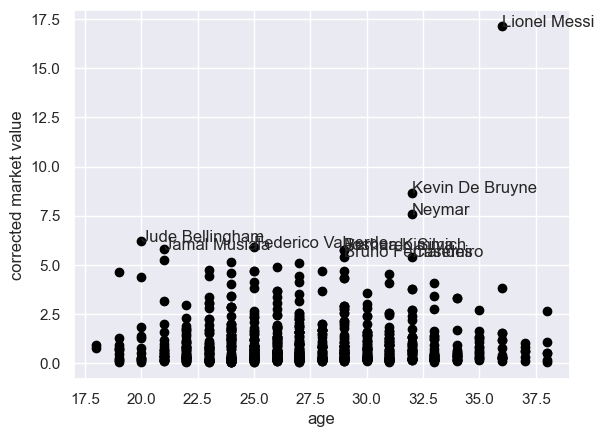

In [13]:
X = players['Age']
y = players['Norm_Value']

plt.scatter(X, y, color='black');
for i, txt in enumerate(players.sort_values('Norm_Value', ascending=False).iloc[:10].Name):
    plt.annotate(txt, (X.iloc[i], y.iloc[i]))

plt.xlabel('age')
plt.ylabel('corrected market value')
plt.show()

We can see that this is definitely in the right direction for a metric of a player's quality, judging by the players that come up at the top of the list. <br>
Let's now use all the available stats, and determine which of those are most important. <br>
Using statsmodels, we can define a multiple linear regression model, and get a more detailed summary that will prove useful. <br>
We'll do backward elimination, and remove the least significant feature at each step, until all features are significant. The criterion will be p-value (at level 0.05), since we care more about interpretability than accuracy. <br>
We should note however that the model is not perfect, since most stats are not independent of each other, and thus collinearity is present. We'll once again ignore this for now, and proceed with the analysis.

In [32]:
selected_stats = ['Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'xG', 'npxG', 'xAG', 'npxG+xAG',
                    'PrgC', 'PrgP', 'PrgR', 'Gls/90', 'Ast/90', 'G+A/90', 'G-PK/90',
                    'G+A-PK/90', 'xG/90', 'xAG/90', 'xG+xAG/90', 'npxG/90', 'npxG+xAG/90',
                    'G-xG', 'G-xG/90', 'G-PK-npxG','G-PK-npxG/90', 'G-PK-npxG+xAG',
                    'G-PK-npxG+xAG/90']
X = players[selected_stats]
# standardise features
X = (X - X.mean()) / X.std()
y = players['Norm_Value']

model = sm.OLS(y, X).fit()

# while the highest p-value is non-significant (at level 5%), remove the feature with the highest p-value
while True:
    max_pvalue_idx = model.pvalues.idxmax()
    max_pvalue = model.pvalues[max_pvalue_idx]

    if max_pvalue < 0.05:
        break

    X = X.drop(columns=max_pvalue_idx)

    model = sm.OLS(y, X).fit()

selected_stats = X.columns
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             Norm_Value   R-squared (uncentered):                   0.230
Model:                            OLS   Adj. R-squared (uncentered):              0.224
Method:                 Least Squares   F-statistic:                              35.18
Date:                Sat, 09 Sep 2023   Prob (F-statistic):                    4.39e-43
Time:                        13:54:09   Log-Likelihood:                         -1467.3
No. Observations:                 831   AIC:                                      2949.
Df Residuals:                     824   BIC:                                      2982.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Here are the results in a more compact form, sorted by p-value and also including the VIF for each feature, which we'll use to tackle the collinearity problem that exists, as mentioned earlier.

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def results_df():
    res = pd.DataFrame()
    res['stat'] = X.columns
    res['p-value'] = model.pvalues.values
    res['coef'] = model.params.values
    res['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    res.sort_values('p-value', inplace=True)
    # res.set_index('stat', inplace=True)
    res.reset_index(inplace=True, drop=True)
    return res

res = results_df()
res

,stat,p-value,coef,VIF
0,PrgP,9.758846e-13,0.504419,1.992513
1,xG+xAG/90,1.383036e-04,0.363351,3.703848
2,npxG+xAG,9.691498e-04,0.964924,34.931403
3,xAG,1.472549e-03,-0.476902,inf
4,G-PK-npxG,1.566108e-03,0.396598,inf
5,Gls,9.372750e-03,-0.547225,18.162575
6,G-PK-npxG+xAG,1.418837e-02,-0.161708,inf
7,Ast,3.110184e-02,0.197989,3.457850


We can see that **PrgP (Progressive Passes)** is the most important stat, followed by **xG+xAG/90 (xGoals + xAssistedGoals per 90)**, **npxG+xAG (non-penalty xGoals + xAssistedGoals)**, and others (more detailed discussion will be at the end, after the final model). <br>
However, using the VIF, we can confirm that there is collinearity present, and this is probably also why there are stats with negative coefficients, even though intuitively we expect that higher numbers for these stats are better. <br>
We'll remove some of the features and re-fit the model, making sure that the remaining stats have a VIF lower than 5. <br>
Specifically, the stats I'm removing and the reasoning behind it are:
* Assists, G-PK-npxG+xAG, Gls: these are the stats with the lowest p-values
* npxG+xAG: it is the stat hith the highest (finite) VIF, and it is obviously highly correlated with xG+xAG/90

In [34]:
X.drop(columns=['Ast', 'G-PK-npxG+xAG', 'Gls', 'npxG+xAG'], inplace=True)
selected_stats = X.columns

model = sm.OLS(y, X).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             Norm_Value   R-squared (uncentered):                   0.213
Model:                            OLS   Adj. R-squared (uncentered):              0.210
Method:                 Least Squares   F-statistic:                              56.06
Date:                Sat, 09 Sep 2023   Prob (F-statistic):                    7.34e-42
Time:                        13:54:09   Log-Likelihood:                         -1476.3
No. Observations:                 831   AIC:                                      2961.
Df Residuals:                     827   BIC:                                      2979.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [35]:
res = results_df()
res

,stat,p-value,coef,VIF
0,PrgP,2.020898e-12,0.482707,1.845783
1,xG+xAG/90,5.013875e-08,0.400258,2.138379
2,xAG,1.590032e-01,0.122456,3.048765
3,G-PK-npxG,2.569175e-01,0.057091,1.023172


#### So there we finally have our results for the most important stats for a midfielder! Let's comment on these stats and their significane. <br>
#### First, we can see that **PrgP (Progressive Passes)** is the most important stat, as noticed before as well. This makes sense, since progressive passes are essential to the build-up of a dangerous attack, however they are not easy to pull off because they will usually need to break opponents' lines and be executed within tight spaces, so players who can make these kind of passes consistently are very valuable. 

#### After that, we have **xG+xAG/90 (xGoals + xAssistedGoals per 90)**. This means that it is important for midfielders to be directly involved in goals, by being at the end of a final ball, or by creating goalscoring chances themselves. Importantly, xG and xAG capture the objective quality of a chance, so they are less volatile metrics than plain old goals and assists. What matters for these is whether the players gets into good goalscoring position, or makes good final balls, regardless of the outcome. <br>

#### Next, we have **xAG**. This is included in the previous stat in a way, however this emphasises for midfielders the importance of creating direct chances for their teammates, regardless of whether these chances are converted or not, since xAG values the pass itself and not the finish, like regular assists do. <br>

#### Finally, we have **G-PK-npxG (Goals-Penalties-NonPenalty xGoals)**. This is one of the stats I added myself earlier, and confirms my expectation of it being an important one. This stat emphasises the significance of actually scoring, rather than just being in good positions to score, like xG does. Particularly, it measures the overperformance of goals in relation to the scoring opportunities the player got into (excluding penalties). While in the short term overperformance might mean that the player is actually less capable than considered and is bound to start seriously underperforming at some point, in reality the best players and indeed midfielders in particular, excel in making the most of their clear chances, which can be rare, depending on their role, since they aren't regulars in the opposition box, while also being able to score goals from positions where scoring is difficult (overperforming their xG), such as goals from outside the box or in between a big crowd.<br>

#### Finally, it is worth noting that of course not every midfielder is expected to excel in all these aspects. Even though the world class ones might do, most will be very good at some of them, depending on their playing style and role. An example that springs to mind is Rodri, one of the best if not the best number 6 in the world, who is not usually much involved in scoring goals, however he is excellent at progressing the ball and occasionally creating direct chances for his teammates. We can confirm using data below:

In [201]:
from scipy.stats import percentileofscore

cols = ['Name', 'Value', 'Norm_Value'] + selected_stats.to_list()
rodri = players[players.Name == 'Rodri'][cols]
all = players[players['90s'] >= 15][cols].reset_index(drop=True)
perc = pd.DataFrame([percentileofscore(all[x], rodri[x])[0] for x in cols])
rodri.loc[1, :] = perc.values.T
rodri.iloc[0, 0] = 'Amount'
rodri.iloc[1, 0] = 'Percentile'
rodri.set_index('Name', inplace=True, drop=True)
rodri.index.name = 'Rodri'
rodri = rodri.map(lambda x: f'{(x):.2f}')
rodri.iloc[0, [0, 3]] = rodri.iloc[0, [0, 3]].apply(lambda x: f'{float(x):,.0f}')
rodri

,Value,Norm_Value,xAG,PrgP,xG+xAG/90,G-PK-npxG
Rodri,,,,,,
Amount,"80,000,000",5.07,4.10,260,0.27,-2.60
Percentile,97.75,97.54,74.69,98.16,56.05,4.41
